<a href="https://colab.research.google.com/github/michaelmml/NLP-Information-Extraction/blob/main/PatentKeywords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examining Concepts from Blockchain Patents

From over a 1000 blockchain related patents over the last 5 years, we are applying structured extraction techniques to identify common themes in these patents and concepts arising from keyword and nounidentification methods.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [4]:
data = pd.read_csv(root_folder+'/PatentBlockchain.csv')
data['patent_date'] = pd.Series(pd.to_datetime(data['patent_date'], format='%d/%m/%Y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patent_abstract  1642 non-null   object        
 1   patent_date      1642 non-null   datetime64[ns]
 2   patent_number    1642 non-null   int64         
 3   patent_title     1642 non-null   object        
 4   patent_year      1642 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 64.3+ KB


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

We see that blockchain patents have grown a low base over the last 5 years, one thing to keep in mind as we analyse the semantics of patents is that there is obviously a lot higher frequency of mentions of any keywords in general. So we have to consider an average over certain time periods.

Text(0.5, 1.0, 'Blockchain Patents over Time')

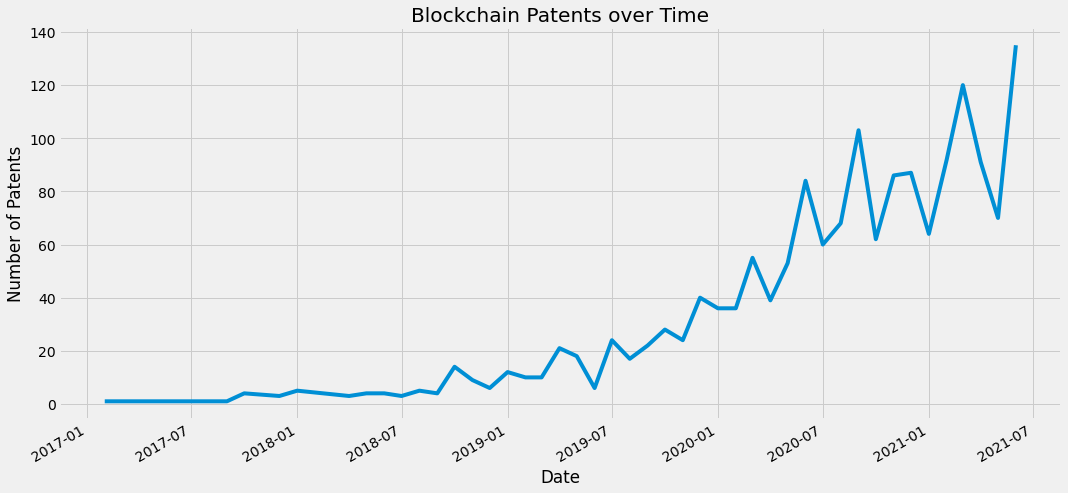

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)]

month_group = data.groupby('year-month')['patent_number'].count().reset_index()

month_group.set_index('year-month')['patent_number'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Blockchain Patents over Time')

In [ ]:
month_group.groupby(month_group['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

# Keyword Analysis and Extraction

Initial data cleaning and analysis then application of TF-IDF (term frequency-inverse document frequency) which is a statistical measure that evaluates how relevant a word is to a document and also Spacy part-of-speech noun identification.

In [8]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Logical to maintain **two data cleaners** with opposing levels of granularity - one will clean the text of short-words, stop-words and any punctuations, which is useful for embedding due to a reduced vocabulary and for looking at words without considering part of speech. The light cleaner is therefore to preserve grammar / PoS and the structure of sentences to identify nouns, adjectives, etc. 

In [11]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [12]:
def text_cleaner_light(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)

    return newString

In [13]:
def plot_wordcloud(year):
    per_year = data[data['patent_year'] == year]
    cleaned_text = per_year['patent_abstract'].apply(lambda x : text_cleaner(x))
    long_string = ','.join(list(cleaned_text.values))
    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    return wordcloud.to_image()

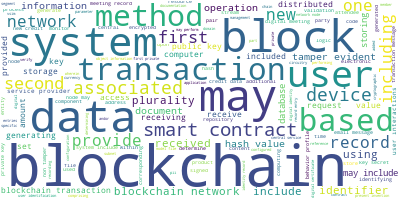

In [14]:
plot_wordcloud(2018)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
data_year = data.groupby(['patent_year'])['patent_abstract'].apply(' '.join).reset_index()
data_year['abstract_clean'] = data_year['patent_abstract'].apply(lambda x : text_cleaner(x))

In [17]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [18]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

The **term frequency** of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. 

The **inverse document frequency** of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

In our case, we are looking at the term frequency of words in a particular time period and comparing against the frequency of words over the set of time periods.

In [19]:
def get_keywords(content_list):
  keywords = []

  cv = CountVectorizer(max_df = 0.85)
  word_count_vector = cv.fit_transform(content_list)

  tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names = cv.get_feature_names()

  for i in range(len(content_list)):
      doc = content_list[i]
      tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
      sorted_items = sort_coo(tf_idf_vector.tocoo())
      keys = extract_topn_from_vector(feature_names,sorted_items,10)
      keywords.append(list(keys.keys()))
  
  return keywords

In [20]:
data_year = pd.concat([data_year, pd.Series(get_keywords(data_year['abstract_clean'].tolist()))], axis = 1)

In [21]:
data_year = data_year.rename(columns={0:"keywords"})

In [22]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot..."
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m..."
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser..."
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth..."
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic..."


Some obvious keywords identified by Tf-idF include "information" and "block" but an interesting word that appears in several of the years is "plurality". From domain knowledge, plurality refers to pluraity of nodes in most cases. Another is "contract" which aligns the application of blockchain in smart contracts due to the ledger framework.

In [ ]:
data_year['keywords'].tolist()

**Rapid Automatic Keyword Extraction (RAKE) algorithm**

In [ ]:
!pip install rake_nltk

In [25]:
from rake_nltk import Rake
rake_nltk_var = Rake()

In [27]:
def rake(text):
    rake_nltk_var.extract_keywords_from_text(text)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()
    return keyword_extracted

In [ ]:
data_year['rake_keywords'] = data_year['patent_abstract'].apply(lambda x : rake(x))
data_year.drop(['patent_abstract', 'abstract_clean'], axis=1)

**Gensim**

In [32]:
from gensim.summarization import keywords

In [33]:
data_year['gensim_keywords'] = data_year['patent_abstract'].apply(lambda x : keywords(x))

In [34]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords,rake_keywords,gensim_keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot...","[two different transactions — one, called bix ...",blockchain\nblockchains\ntransaction\ntransact...
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m...",[third smart contract may autopopulate post me...,blockchain\nincluded\nincluding\nincludes\ntra...
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser...",[(“ safetpa ”) transforms fractional equity ow...,data\nblockchain\nblockchains\nincluding\nincl...
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth...",[system may include multiple proxy servers geo...,data\nblockchains\nblockchained\nblockchain tr...
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic...",[certifying product authenticity using physica...,data\nblockchains\nblockchain transaction\nbas...


**Spacy**

In [38]:
import spacy
nlp_keywords = spacy.load("en_core_web_sm")

In [41]:
def spacy_keywords(text):
    doc = nlp_keywords(text)
    return doc.ents

In [42]:
data_year['spacy_keywords'] = data_year['patent_abstract'].apply(lambda x : spacy_keywords(x))

In [44]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords,rake_keywords,gensim_keywords,spacy_keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot...","[two different transactions — one, called bix ...",blockchain\nblockchains\ntransaction\ntransact...,"((IDMS), (third), (BIX, Security, Policy, Prov..."
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m...",[third smart contract may autopopulate post me...,blockchain\nincluded\nincluding\nincludes\ntra...,"((One), (one), (GPS), (more, than, one), (at, ..."
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser...",[(“ safetpa ”) transforms fractional equity ow...,data\nblockchain\nblockchains\nincluding\nincl...,"((API), (API), (third), (one), (blockchain), (..."
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth...",[system may include multiple proxy servers geo...,data\nblockchains\nblockchained\nblockchain tr...,"((first), (first), (blockchain), (first), (sec..."
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic...",[certifying product authenticity using physica...,data\nblockchains\nblockchain transaction\nbas...,"((first), (first), (blockchain), (first), (sec..."


In [46]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = data_year['abstract_clean'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['invention', 'describes', 'identity', 'management', 'system', 'based', 'concept', 'peer', 'protocols', 'public', 'identities', 'ledger', 'system', 'manages', 'digital', 'identities', 'digital', 'objects', 'contain', 'attributes', 'used', 'identification', 'persons', 'entities', 'system', 'making', 'identity', 'claims', 'identity', 'objects']


In [47]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 9), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 6), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2)]


In [49]:
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

doc_lda = lda_model[corpus]

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

## Spacy, Nouns and Matcher

Initially, let's consider simply searching for nouns and their frequency across time periods in the patents.

In [36]:
data['patent_abstract'] = data['patent_abstract'].apply(lambda x : text_cleaner_light(x))

In [37]:
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_sm')

In [38]:
def common_nouns(year):
    # Spacy to find nouns
    per_year = data[data['patent_year'] == year]
    long_string = '. '.join(list(per_year['patent_abstract'].values))
    
    doc = nlp(long_string)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    noun_freq = Counter(nouns)
    top_nouns = noun_freq.most_common(25)
    return noun_freq, top_nouns

In [39]:
noun_freq, top_nouns = common_nouns(2019)

In [40]:
top_nouns

[('blockchain', 559),
 ('datum', 319),
 ('block', 297),
 ('device', 255),
 ('system', 251),
 ('transaction', 242),
 ('network', 192),
 ('method', 167),
 ('user', 148),
 ('ledger', 137),
 ('information', 117),
 ('request', 100),
 ('entity', 96),
 ('value', 94),
 ('plurality', 93),
 ('node', 87),
 ('hash', 86),
 ('service', 84),
 ('computer', 84),
 ('contract', 77),
 ('data', 76),
 ('message', 73),
 ('identity', 70),
 ('key', 66),
 ('server', 63)]

The standout noun is "datum" but that is due to the "token.lemma_" operation which converts data to datum. Some of the nouns hint towards the applications of blockchain, i,e, transaction, contract and identity.

In [57]:
def noun_extraction(text):
    patterns = [r'\b(?i)' + 'transaction' + r'\b']

    output = []
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag

In [58]:
data['check_nouns'] = data['patent_abstract'].apply(noun_extraction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Flags not at the start of the expression '\\b(?i)transaction\\b'
  import sys


In [60]:
data[data['check_nouns'] != 0]

,patent_abstract,patent_date,patent_number,patent_title,patent_year,year-month,check_nouns
0,using a blockchain transaction acceleration sy...,2020-05-26,10664469,Accelerating transaction deliveries in blockch...,2020,2020-05-01,1
1,using a blockchain transaction acceleration sy...,2021-06-22,11042535,Accelerating transaction deliveries in blockch...,2021,2021-06-01,1
2,a distributed transaction ledger is used to c...,2021-03-30,10964145,Access control system using blockchain ledger,2021,2021-03-01,1
3,implementations of the present specification i...,2020-04-07,10615985,Achieving consensus among network nodes in a d...,2020,2020-04-01,1
4,implementations of the present specification i...,2020-07-07,10708066,Achieving consensus among network nodes in a d...,2020,2020-07-01,1
...,...,...,...,...,...,...,...
1616,a computer implemented method for validating u...,2021-01-12,10891383,Validating computer resource usage,2021,2021-01-01,1
1621,techniques are provided for validating sensor ...,2020-09-15,10778426,Validation of sensor data using a blockchain,2020,2020-09-01,1
1622,an example operation may include one or more o...,2021-03-02,10937253,Validation of vehicle data via blockchain,2021,2021-03-01,1
1637,systems and methods as described herein may in...,2020-05-19,10659219,Workflow management via distributed ledgers an...,2020,2020-05-01,1
